In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [3]:
# --- 1. 데이터 로드 및 전처리 ---
df = pd.read_csv('/content/drive/MyDrive/Col/머신러닝 9주차/TSLA.csv')

# NA 값 제거 (혹시 모를 결측치)
df = df.dropna()

# 사용할 피처 (입력 4개)와 타겟 (출력 1개) 분리
features_to_use = ['Open', 'High', 'Low', 'Close']
target_col = 'Close'

df_features = df[features_to_use]
df_target = df[[target_col]] # [[ ]]를 사용해 DataFrame 형태로 유지

In [4]:
# --- 2. 정규화 (입력과 출력을 별도로 스케일링) ---
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(df_features)
target_scaled = scaler_target.fit_transform(df_target)

In [5]:
# --- 3. 시퀀스 생성 (Multi-variate) ---
window = 30   # 최근 30일간의 O,H,L,C 데이터 -> 다음날 Close 예측
X, y = [], []

for i in range(len(features_scaled) - window):
    # i부터 i+window 까지의 피처 (Open, High, Low, Close)
    X.append(features_scaled[i:i+window])
    # i+window 시점의 타겟 (Close)
    y.append(target_scaled[i+window])

X, y = np.array(X), np.array(y)

# X의 shape: (샘플 수, 30, 4)
# y의 shape: (샘플 수, 1)
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (2926, 30, 4), y shape: (2926, 1)


In [6]:
# --- 4. 훈련 / 테스트 데이터 분리 (8:2) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"총 샘플 수: {len(X)}")
print(f"훈련 샘플 수: {len(X_train)}")
print(f"테스트 샘플 수: {len(X_test)}")

# 입력 shape 확인
input_shape = (window, 4) # (30, 4)

총 샘플 수: 2926
훈련 샘플 수: 2340
테스트 샘플 수: 586


In [7]:
# --- 5. 모델 1: SimpleRNN ---
print("\n--- SimpleRNN 모델 훈련 시작 ---")
tf.keras.utils.set_random_seed(42)
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=input_shape),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0, validation_data=(X_test, y_test))
print("SimpleRNN 훈련 완료.")


--- SimpleRNN 모델 훈련 시작 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


SimpleRNN 훈련 완료.


In [8]:
# --- 6. 모델 2: LSTM ---
print("\n--- LSTM 모델 훈련 시작 ---")
tf.keras.utils.set_random_seed(42)
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=input_shape),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0, validation_data=(X_test, y_test))
print("LSTM 훈련 완료.")


--- LSTM 모델 훈련 시작 ---
LSTM 훈련 완료.


In [9]:
# --- 7. 예측 및 평가 (MSE) ---
pred_rnn = model_rnn.predict(X_test)
pred_lstm = model_lstm.predict(X_test)

# MSE는 정규화된 스케일에서 계산
mse_rnn = mean_squared_error(y_test, pred_rnn)
mse_lstm = mean_squared_error(y_test, pred_lstm)

print("\n--- 모델 평가 (Scaled MSE) ---")
print(f"SimpleRNN (Test MSE): {mse_rnn:.6f}")
print(f"LSTM (Test MSE):      {mse_lstm:.6f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

--- 모델 평가 (Scaled MSE) ---
SimpleRNN (Test MSE): 0.000770
LSTM (Test MSE):      0.000853


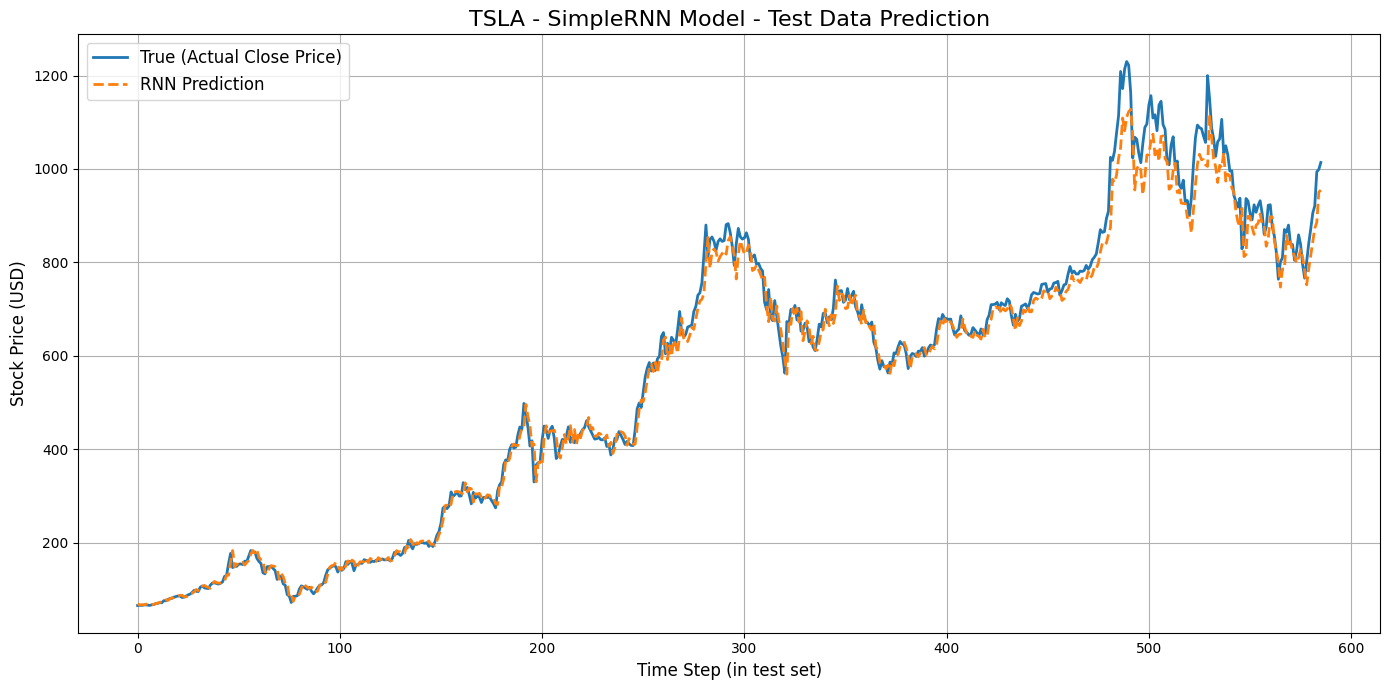

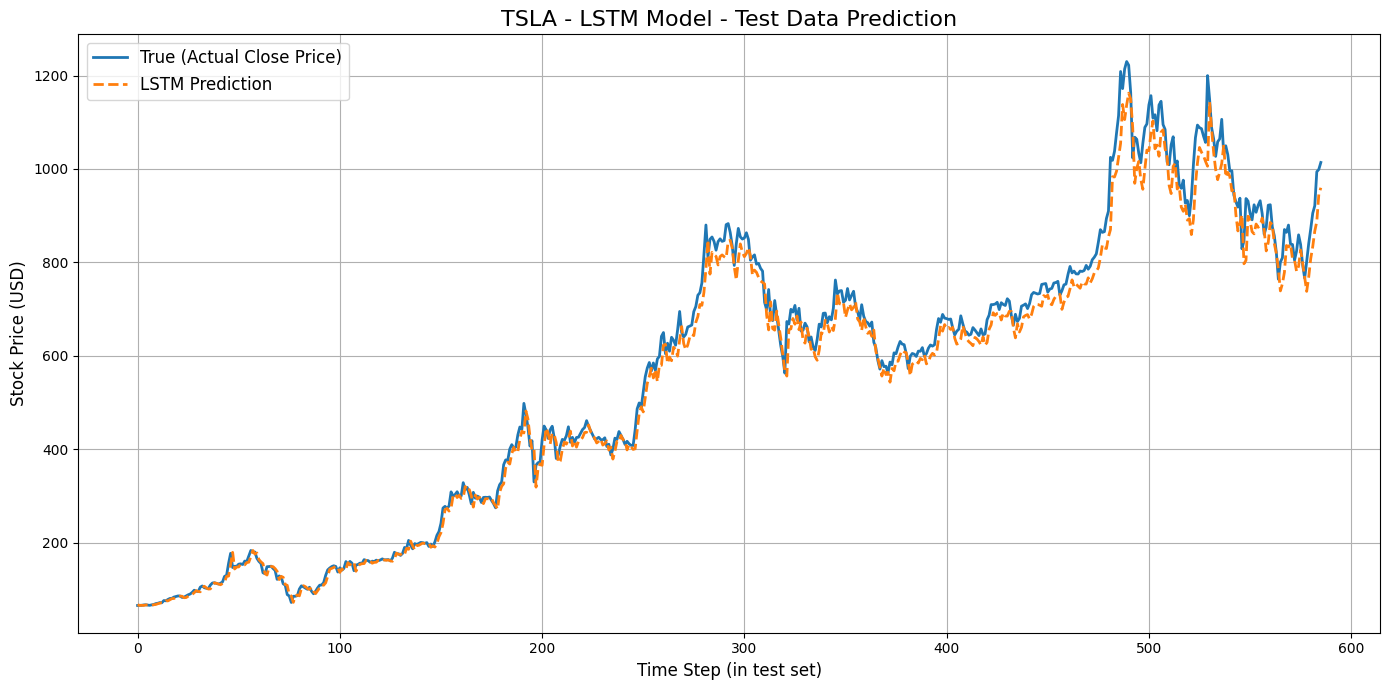

In [10]:
# --- 8. 그래프화 (원래 스케일 - 달러 $ - 로 변환) ---
# scaler_target을 사용해 원래 가격으로 복원
y_test_inv = scaler_target.inverse_transform(y_test)
pred_rnn_inv = scaler_target.inverse_transform(pred_rnn)
pred_lstm_inv = scaler_target.inverse_transform(pred_lstm)

test_indices = np.arange(len(y_test_inv))

# SimpleRNN 그래프
plt.figure(figsize=(14, 7))
plt.title('TSLA - SimpleRNN Model - Test Data Prediction', fontsize=16)
plt.plot(test_indices, y_test_inv, label='True (Actual Close Price)', linewidth=2)
plt.plot(test_indices, pred_rnn_inv, label='RNN Prediction', linestyle='--', linewidth=2)
plt.legend(fontsize=12)
plt.xlabel('Time Step (in test set)', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.grid(True)
plt.tight_layout()

# LSTM 그래프
plt.figure(figsize=(14, 7))
plt.title('TSLA - LSTM Model - Test Data Prediction', fontsize=16)
plt.plot(test_indices, y_test_inv, label='True (Actual Close Price)', linewidth=2)
plt.plot(test_indices, pred_lstm_inv, label='LSTM Prediction', linestyle='--', linewidth=2)
plt.legend(fontsize=12)
plt.xlabel('Time Step (in test set)', fontsize=12)
plt.ylabel('Stock Price (USD)', fontsize=12)
plt.grid(True)
plt.tight_layout()